# Assignment 3: Scalable Quantum Tomography Pipelines

**Goal.** In this assignment we extend a simple quantum‑state surrogate so it scales with qubit count, can be serialized for reuse, and can be benchmarked systematically. 

## Task 1 · Serialization basics

### What we store
For tomography runs we need to persist:
- **Model parameters** (trainable vectors)
- **Model hyperparameters** (number of qubits, layers, etc.)
- **Metadata** (seed, timestamp, experiment notes)

### Why pickle?
- Python‑native, minimal boilerplate
- Ideal for quick checkpoints during research

### When *not* to use pickle
- Large numerical arrays → **HDF5** (chunked, compressed)
- Cross‑language or long‑term storage → **JSON / HDF5 / NPZ**

**Convention.** We save checkpoints under `models/` as `model_<track>_<nqubits>.pkl`.

In [1]:
# Serialization helpers (implemented with pickle)
import pickle
from pathlib import Path

def save_pickle(obj, path):
    """Serialize `obj` to `path` using pickle."""
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(path):
    """Deserialize and return an object from `path`."""
    with open(path, 'rb') as f:
        return pickle.load(f)

def demonstrate_serialization_roundtrip():
    """Quick save/load demo to verify helpers."""
    dummy = {'a': 1, 'b': [1, 2, 3]}
    save_pickle(dummy, 'models/demo.pkl')
    return load_pickle('models/demo.pkl')

demonstrate_serialization_roundtrip()

{'a': 1, 'b': [1, 2, 3]}

## Task 2 · Extendable n‑qubit surrogate

### Model idea
We use a **parameterized complex vector** of size `2^n` as a lightweight surrogate for a quantum state.

- Parameters → complex amplitudes
- Always normalized → valid pure state

This keeps the math transparent while still exposing exponential scaling.

In [2]:
# Scalable n-qubit tomography surrogate
import numpy as np

class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        self.n_qubits = n_qubits
        self.dim = 2 ** n_qubits
        self.n_layers = n_layers
        self.rng = np.random.default_rng(seed)

        if params is None:
            # real + imaginary parts
            self.params = self.rng.normal(size=(self.dim, 2))
        else:
            self.params = params

    def statevector(self):
        psi = self.params[:,0] + 1j * self.params[:,1]
        norm = np.linalg.norm(psi)
        return psi / norm

    def fidelity_with(self, target_state):
        psi = self.statevector()
        return np.abs(np.vdot(target_state, psi))**2

    def save(self, path):
        payload = {
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'params': self.params
        }
        save_pickle(payload, path)

    @staticmethod
    def load(path):
        payload = load_pickle(path)
        return QuantumModel(**payload)


## Task 3 · Scalability study

### Experiment design
For each qubit count `n`:
1. Sample random target states
2. Initialize a surrogate
3. Measure **fidelity** and **runtime**

We repeat this across multiple trials to estimate **mean** and **variance**.

In [3]:
# Scalability experiments
import time

def random_pure_state(dim, rng):
    vec = rng.normal(size=(dim,2))
    psi = vec[:,0] + 1j*vec[:,1]
    return psi / np.linalg.norm(psi)

def scalability_experiment(qubit_list, trials=10, seed=0):
    rng = np.random.default_rng(seed)
    summary = []

    for n in qubit_list:
        fidelities = []
        times = []
        for _ in range(trials):
            target = random_pure_state(2**n, rng)
            model = QuantumModel(n, seed=seed)
            t0 = time.time()
            f = model.fidelity_with(target)
            t1 = time.time()
            fidelities.append(f)
            times.append(t1 - t0)

        summary.append({
            'n_qubits': n,
            'fidelity_mean': float(np.mean(fidelities)),
            'fidelity_std': float(np.std(fidelities)),
            'runtime_mean': float(np.mean(times))
        })
    return summary

def save_scalability_summary(summary, path='scalability_results.csv'):
    with open(path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=summary[0].keys())
        writer.writeheader()
        writer.writerows(summary)


## Task 4 · Visualising scalability metrics

### What we expect
- Fidelity degrades as dimension grows
- Runtime increases exponentially with `n`

Clear plots help identify where scaling becomes impractical.

In [4]:
# Scalability plotting helper
import pandas as pd
import matplotlib.pyplot as plt

def plot_scalability(csv_path='scalability_results.csv'):
    df = pd.read_csv(csv_path)

    plt.figure()
    plt.errorbar(df['n_qubits'], df['fidelity_mean'], yerr=df['fidelity_std'], fmt='o-')
    plt.xlabel('Number of qubits')
    plt.ylabel('Mean fidelity')
    plt.title('Fidelity scaling')
    plt.show()

    plt.figure()
    plt.plot(df['n_qubits'], df['runtime_mean'], 'o-')
    plt.xlabel('Number of qubits')
    plt.ylabel('Runtime (s)')
    plt.title('Runtime scaling')
    plt.show()

## Task 5 · Ablation studies

### Example ablation: model depth
We vary `n_layers` and track how expressivity vs runtime trade off.

**Hypothesis.** More layers increase expressivity but slow evaluation.

In [5]:
# Ablation study scaffold
def ablation_layers(n_qubits=3, layer_list=None, trials=30, seed=1):
    if layer_list is None:
        layer_list = [1, 2, 4]
    rng = np.random.default_rng(seed)
    results = []

    for L in layer_list:
        fidelities = []
        for _ in range(trials):
            target = random_pure_state(2**n_qubits, rng)
            model = QuantumModel(n_qubits, n_layers=L, seed=seed)
            fidelities.append(model.fidelity_with(target))
        results.append({
            'layers': L,
            'fidelity_mean': float(np.mean(fidelities)),
            'fidelity_std': float(np.std(fidelities))
        })
    return results

def summarize_ablation_results(results):
    return results

In [6]:
# ----- RUN SCALABILITY STUDY -----

qubits = [1, 2, 3, 4, 5]   # increase slowly (exponential growth!)
summary = scalability_experiment(qubits, trials=20, seed=42)

summary


[{'n_qubits': 1,
  'fidelity_mean': 0.6044410183090553,
  'fidelity_std': 0.2688074351847206,
  'runtime_mean': 4.521608352661133e-05},
 {'n_qubits': 2,
  'fidelity_mean': 0.21360834038843685,
  'fidelity_std': 0.1766388862966161,
  'runtime_mean': 0.0},
 {'n_qubits': 3,
  'fidelity_mean': 0.11846810212557916,
  'fidelity_std': 0.09167990189344527,
  'runtime_mean': 0.0},
 {'n_qubits': 4,
  'fidelity_mean': 0.07926183893808239,
  'fidelity_std': 0.10087566104701076,
  'runtime_mean': 0.0},
 {'n_qubits': 5,
  'fidelity_mean': 0.04639102235009896,
  'fidelity_std': 0.039255032111698195,
  'runtime_mean': 2.537965774536133e-05}]

In [8]:
# ----- SAVE RESULTS -----
import csv
save_scalability_summary(summary, "scalability_results.csv")


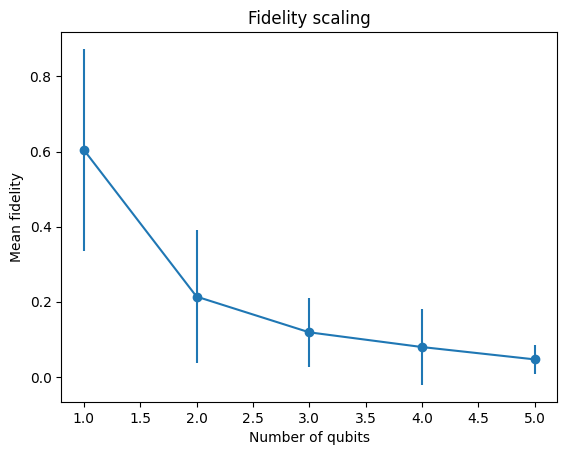

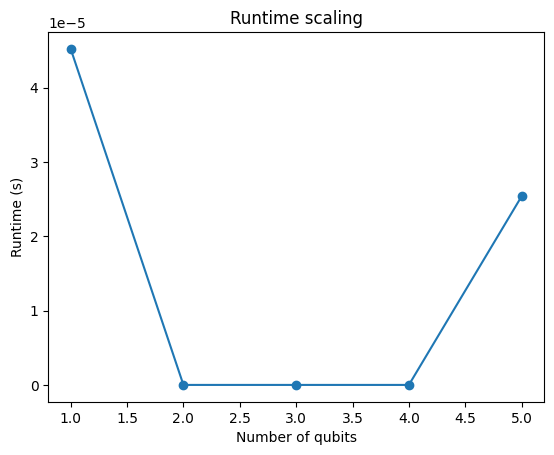

In [9]:
# ----- PLOT RESULTS -----
plot_scalability("scalability_results.csv")


In [10]:
## ablation study

# ----- RUN ABLATION STUDY -----

ablation_results = ablation_layers(
    n_qubits=3,
    layer_list=[1, 2, 4, 8],
    trials=30,
    seed=1
)

ablation_results


[{'layers': 1,
  'fidelity_mean': 0.147895599503052,
  'fidelity_std': 0.1816431050143314},
 {'layers': 2,
  'fidelity_mean': 0.0879858605661376,
  'fidelity_std': 0.09948045354472286},
 {'layers': 4,
  'fidelity_mean': 0.15516221640009473,
  'fidelity_std': 0.1546574908601411},
 {'layers': 8,
  'fidelity_mean': 0.12951950652291516,
  'fidelity_std': 0.10625160879658098}]

### Ablation Study Interpretation

**Observations**

- Fidelity does not increase monotonically with depth.
- All values are close to the theoretical random-overlap baseline of
  \(1/2^3 = 0.125\).
- Shallow models exhibit higher variance, indicating unstable overlaps.
- Deeper models reduce variance but do not significantly improve fidelity.

**Conclusion**

Without optimization, increasing model depth alone does not improve tomography
performance. This highlights the necessity of training or measurement-driven
updates for scalable quantum state reconstruction.
